# ARIMA

## Zasada działania

In [62]:
import pandas as pd

In [63]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

# Model

[Opis](https://medium.com/@er.iit.pradeep09/time-series-forecasting-using-arima-caa84d52463b)

In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [65]:
test_df = data.loc[data.index >= 901].copy()
train_df =  data.loc[data.index < 901].copy()

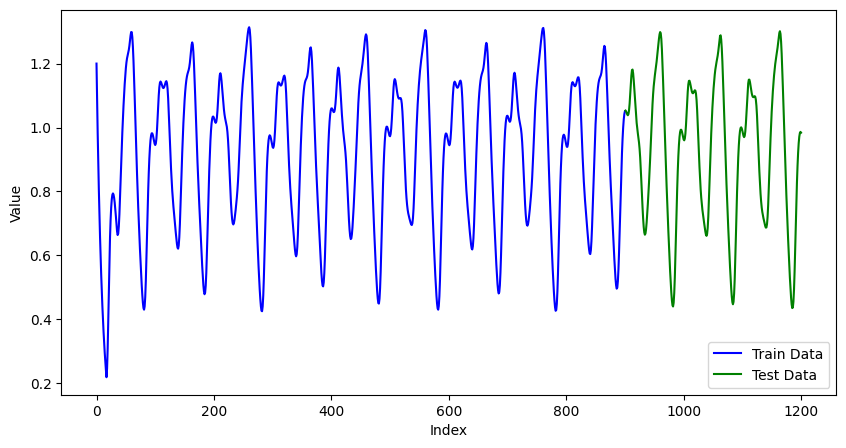

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.index, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.index, test_df.y, label="Test Data", color='green')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

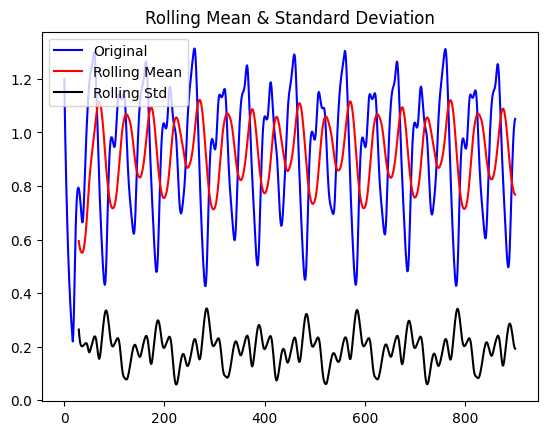

Results of Dickey-Fuller Test:
ADF Statistic: -8.136167849656012
p-value: 1.0578055898567502e-12
Critical Values:
	1%: -3.4378113191216397
	5%: -2.8648337072350074
	10%: -2.5685238062308366


In [67]:
def check_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

timeseries = train_df.y
check_stationarity(timeseries)

Z testu wynika, że szereg jest stacjonarny (p-value < 0.05). Gdyby tak nie było trzeba by dokonać transformacji, aby do takiego doprowadzić, wykonujemy metodę `.diff()` na danych, może wielokrotnie. Pozwala to zbadać jaki powinien być hiperparametr `d`. Dla przykładu poniżej analiza jednokrotnego `diff`. Tutaj `diff` nie jest potrzebny więc `d` = 0.

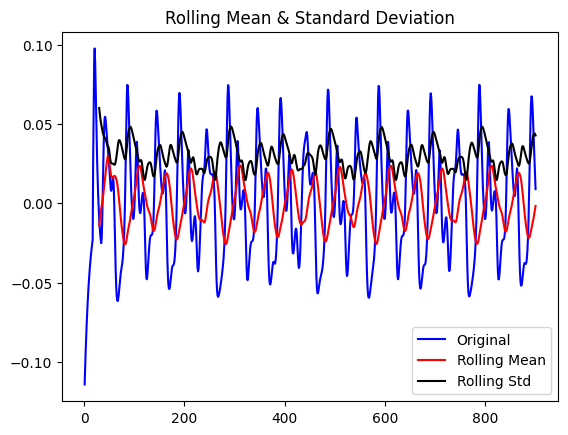

Results of Dickey-Fuller Test:
ADF Statistic: -6.905464568617435
p-value: 1.250572105397213e-09
Critical Values:
	1%: -3.437819842246547
	5%: -2.8648374649929753
	10%: -2.5685258078777093


In [68]:
def check_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

timeseries = train_df.y.diff()
check_stationarity(timeseries.dropna())

In [69]:
def plot_pacf_acf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
    plot_acf(timeseries.dropna(), lags=40, ax=ax1)
    plot_pacf(timeseries.dropna(), lags=40, ax=ax2)
    plt.show()

Teraz sprawdzimy `ACF` i `PACF` aby dobrać hiperparametry `p` i `q`.

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


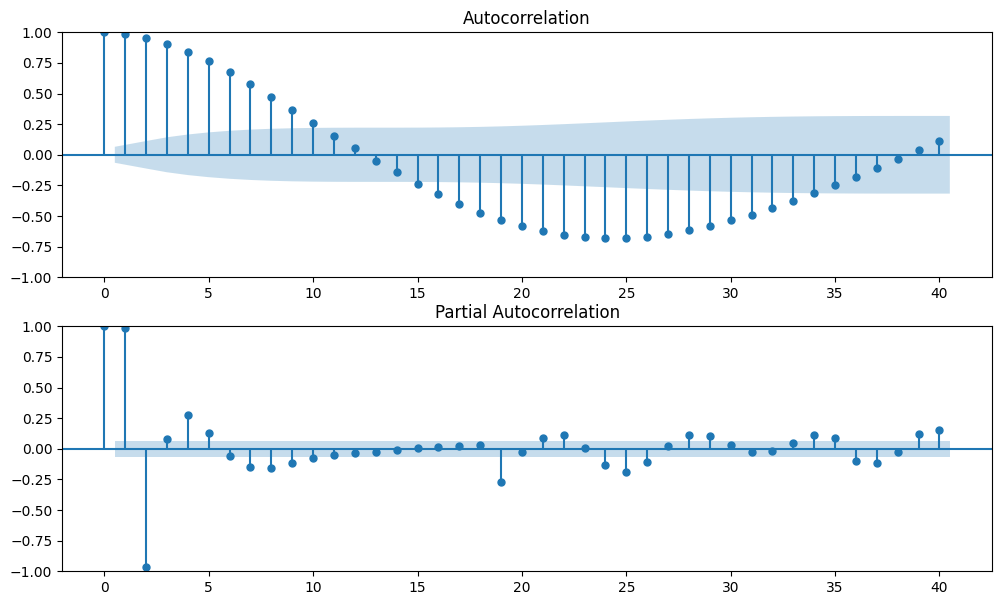

In [70]:
plot_pacf_acf(train_df.y)

Na podstawie wykresów można wyestymować `p` = 3 i `q` = 10.

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  901
Model:                ARIMA(3, 0, 10)   Log Likelihood                4229.149
Date:                Tue, 11 Apr 2023   AIC                          -8428.297
Time:                        17:47:02   BIC                          -8356.245
Sample:                             0   HQIC                         -8400.774
                                - 901                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9086      0.032     28.697      0.000       0.847       0.971
ar.L1          2.8015      0.022    126.992      0.000       2.758       2.845
ar.L2         -2.6356      0.045    -58.114      0.0

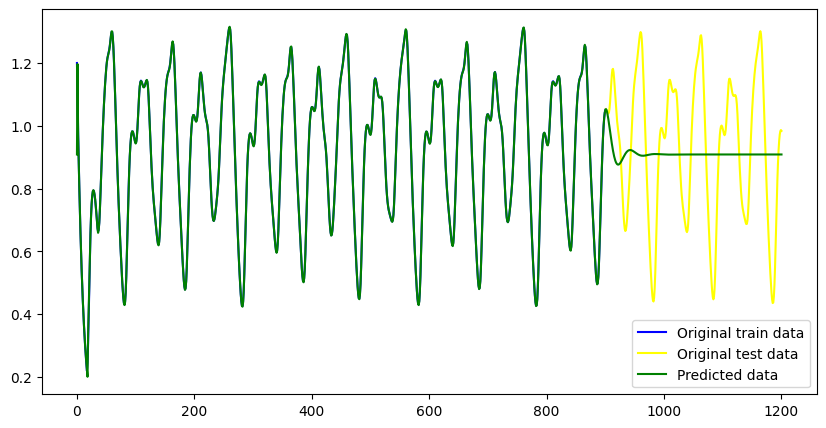

In [71]:
def run_model(model_params, train, test):
    model = ARIMA(train, order = model_params)
    model_fit = model.fit()
    print(model_fit.summary())
    predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
    rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
    print("RSME:", rmse)
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, color='blue', label='Original train data')
    plt.plot(test.index, test, color='yellow', label='Original test data')
    plt.plot(list(train.index) + list(test.index), predictions.predicted_mean, color='green', label='Predicted data')
    plt.legend()
    plt.show()

# model_params = (p, d, q)
train = train_df.y.copy()
test = test_df.y.copy()

run_model((3,0,10), train, test)

Wynik nie jest najciekawszy, dlatego należy poszukać najlepszych parametrów dla modelu

In [72]:
p_params = [1, 2, 3, 4]
d_params = [0,1,2]
q_params = [1,3,5,7,9,11]
best_rmse = np.inf
best_params = None
result_val = []
train = train_df.y.copy()
test = test_df.y.copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=1 --- rmse=0.23497341586654785


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=3 --- rmse=0.22995322128033838
p_val=1 d_val=0 q_val=5 --- rmse=0.22767940668098277


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=7 --- rmse=0.22830914335493646


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=9 --- rmse=0.22824095067410077


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=11 --- rmse=0.2283960059744274


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=1 --- rmse=0.3411761570890557


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=3 --- rmse=0.2630519537767908
p_val=1 d_val=1 q_val=5 --- rmse=0.23786931202472508


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=7 --- rmse=0.23589759045623887


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=1 q_val=9 --- rmse=0.2318677868454701


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=11 --- rmse=0.24846381732584363
p_val=1 d_val=2 q_val=1 --- rmse=6.4401606863812
p_val=1 d_val=2 q_val=3 --- rmse=2.383764371919243
p_val=1 d_val=2 q_val=5 --- rmse=2.651378581710182


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=7 --- rmse=17.574395069986327


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=2 q_val=9 --- rmse=0.2543292876179992


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=11 --- rmse=10.729040934042636
p_val=2 d_val=0 q_val=1 --- rmse=0.23022180781966567


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=0 q_val=3 --- rmse=0.23100447737764412
p_val=2 d_val=0 q_val=5 --- rmse=0.23109579883122144


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=0 q_val=7 --- rmse=0.23079643607906944


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=9 --- rmse=0.21586448019141405


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=11 --- rmse=0.21195614978078728
p_val=2 d_val=1 q_val=1 --- rmse=0.2304539880131539
p_val=2 d_val=1 q_val=3 --- rmse=0.23396139785943756
p_val=2 d_val=1 q_val=5 --- rmse=0.2321529375667259


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=7 --- rmse=0.23700811906785207
p_val=2 d_val=1 q_val=9 --- rmse=0.23040590064897212


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=11 --- rmse=0.23483958086178652


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=2 q_val=1 --- rmse=3.6599138600615815
p_val=2 d_val=2 q_val=3 --- rmse=1.268326143662397
p_val=2 d_val=2 q_val=5 --- rmse=2.0325985730970713


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=7 --- rmse=1.2700140712843382


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=9 --- rmse=2.2613680486031353


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=2 q_val=11 --- rmse=2.4962657274168185


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=1 --- rmse=0.6782498597035826


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=3 --- rmse=0.23072329356320834
p_val=3 d_val=0 q_val=5 --- rmse=0.23380808080272336


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=0.23115403755997074


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=9 --- rmse=0.22751901054618615


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=0 q_val=11 --- rmse=0.22872560734532316


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=1 --- rmse=0.2331721766877772
p_val=3 d_val=1 q_val=3 --- rmse=0.24504310482584496


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

p_val=3 d_val=1 q_val=5 --- rmse=0.24742581617640097
p_val=3 d_val=1 q_val=7 --- rmse=0.23172599202758767


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=9 --- rmse=0.4314052954633842


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=11 --- rmse=0.3895815708850513


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=1 --- rmse=2.0451307227683007


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=3 --- rmse=1.3678611155511833
p_val=3 d_val=2 q_val=5 --- rmse=2.0387926523139006


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=7 --- rmse=0.6262663245978977


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=9 --- rmse=0.7920262745810976


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=11 --- rmse=1.4589933128673869


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=1 --- rmse=0.24094574156411033


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=3 --- rmse=0.22096976859393527
p_val=4 d_val=0 q_val=5 --- rmse=0.2069416293958344


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=7 --- rmse=0.2142639813920789


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=9 --- rmse=0.21600880376454631


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=11 --- rmse=0.21921904672215314


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=1 --- rmse=0.23181970687278042


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=3 --- rmse=2.0287979741365487


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=5 --- rmse=0.24860322652129294
p_val=4 d_val=1 q_val=7 --- rmse=0.4439388574399592


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=9 --- rmse=0.38923285665444884


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=11 --- rmse=0.22829440247648858
p_val=4 d_val=2 q_val=1 --- rmse=1.3428641838438216
p_val=4 d_val=2 q_val=3 --- rmse=1.5000434790651267
p_val=4 d_val=2 q_val=5 --- rmse=2.02026655518898


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=7 --- rmse=1.9123776553439793


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p_val=4 d_val=2 q_val=9 --- rmse=1.261153953665376


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=11 --- rmse=2.58915773574455
best_params=(4, 0, 5)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  901
Model:                 ARIMA(4, 0, 5)   Log Likelihood                4249.245
Date:                Tue, 11 Apr 2023   AIC                          -8476.491
Time:                        17:57:40   BIC                          -8423.652
Sample:                             0   HQIC                         -8456.307
                                - 901                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9158      0.017     53.556      0.000       0.882       0.949
ar.L1          3.5918      0.058     61.770      0.000       3.478       3.706
ar.L2         -4.9509      0.169    -29.348      0.0

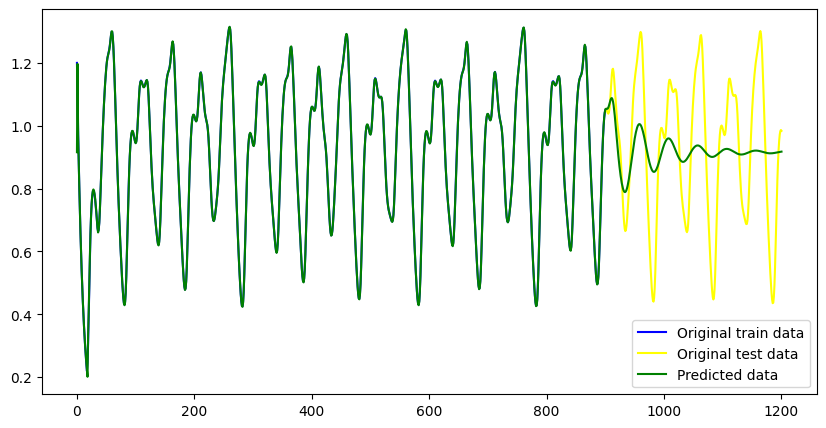

In [73]:
run_model(best_params, train, test)

## Porównanie dla kilku zbiorów danych

In [74]:
from statsmodels.tsa.arima.model import ARIMA

### Mackey Glass

In [75]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

In [76]:
test_df = data.loc[data.index >= 701].copy()
train_df =  data.loc[data.index < 701].copy()

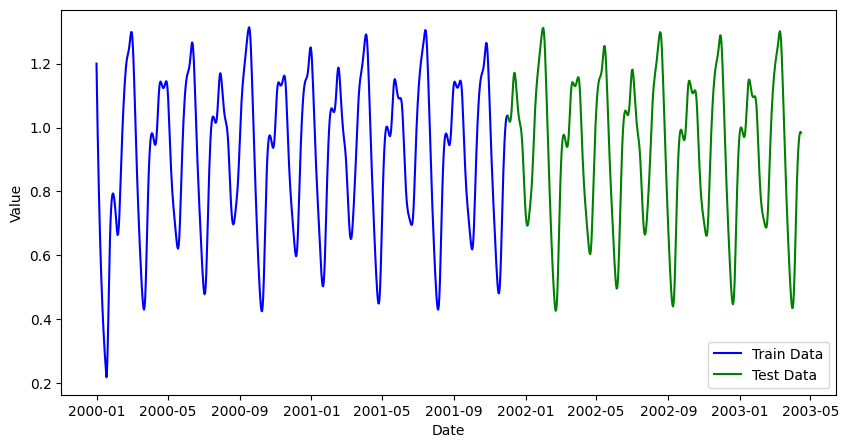

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
p_params = [1, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [1, 3, 5, 7]
best_rmse = np.inf
best_params = None
result_val = []
train = data.iloc[:800]["y"].copy()
test = data.iloc[800:1300]["y"].copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=1 --- rmse=0.22804687218978273


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=3 --- rmse=0.2324397225977067


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=5 --- rmse=0.22805333912848993


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=0 q_val=7 --- rmse=0.2272177120324661


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=1 --- rmse=0.3736589620080373


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=3 --- rmse=0.25642812020633743


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=5 --- rmse=0.23412835508922092
p_val=1 d_val=1 q_val=7 --- rmse=0.2423580863648798
p_val=1 d_val=2 q_val=1 --- rmse=4.505675007398722
p_val=1 d_val=2 q_val=3 --- rmse=2.3643340757954343
p_val=1 d_val=2 q_val=5 --- rmse=2.11150954025068


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=7 --- rmse=2.9085945050107047


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=1 --- rmse=0.23797954108704245
p_val=3 d_val=0 q_val=3 --- rmse=0.22837263653181167
p_val=3 d_val=0 q_val=5 --- rmse=0.22923801168249364


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=0.2293395868801542
p_val=3 d_val=1 q_val=1 --- rmse=0.22848145712570264
p_val=3 d_val=1 q_val=3 --- rmse=0.2273118629366858


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

p_val=3 d_val=1 q_val=5 --- rmse=0.2796154849853296
p_val=3 d_val=1 q_val=7 --- rmse=0.23509261846212254
p_val=3 d_val=2 q_val=1 --- rmse=0.3193984945289014
p_val=3 d_val=2 q_val=3 --- rmse=0.6704279492676045


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=5 --- rmse=0.3949844076024615
p_val=3 d_val=2 q_val=7 --- rmse=10.796062434537088


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=1 --- rmse=0.23931844290482837


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=3 --- rmse=0.22876350793411596


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=5 --- rmse=0.21730142277518177


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=7 --- rmse=0.22179026255322945
p_val=4 d_val=1 q_val=1 --- rmse=0.2279900966822626


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

p_val=4 d_val=1 q_val=3 --- rmse=0.2287807911661563


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=5 --- rmse=0.23124035511822408


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=7 --- rmse=0.428403245508888


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=1 --- rmse=0.747108970066931
p_val=4 d_val=2 q_val=3 --- rmse=0.5854414504875207
p_val=4 d_val=2 q_val=5 --- rmse=0.36288862259135674


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=7 --- rmse=1.1058451595652745


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=1 --- rmse=0.22862453671053387
p_val=5 d_val=0 q_val=3 --- rmse=0.2263959246863853
p_val=5 d_val=0 q_val=5 --- rmse=0.21695464252618998


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=7 --- rmse=0.21730963262855338


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=1 q_val=1 --- rmse=0.22887019190673347


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=1 q_val=3 --- rmse=0.22863434361702883


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=5 --- rmse=0.2312012397183883


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=7 --- rmse=0.8563595228709313
p_val=5 d_val=2 q_val=1 --- rmse=1.316803954097542
p_val=5 d_val=2 q_val=3 --- rmse=0.5976184863994887
p_val=5 d_val=2 q_val=5 --- rmse=0.2737321485975356


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=2 q_val=7 --- rmse=3.061738325686062
best_params=(5, 0, 5)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
model = ARIMA(train_df["y"], order=best_params)
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(start=data.index[0], end=data.index[-1]).to_frame()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  701
Model:                 ARIMA(5, 0, 5)   Log Likelihood                3238.222
Date:                Tue, 11 Apr 2023   AIC                          -6452.445
Time:                        18:01:26   BIC                          -6397.814
Sample:                             0   HQIC                         -6431.328
                                - 701                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9229      0.020     45.164      0.000       0.883       0.963
ar.L1          3.7012      0.030    124.245      0.000       3.643       3.760
ar.L2         -5.3483      0.055    -97.902      0.0

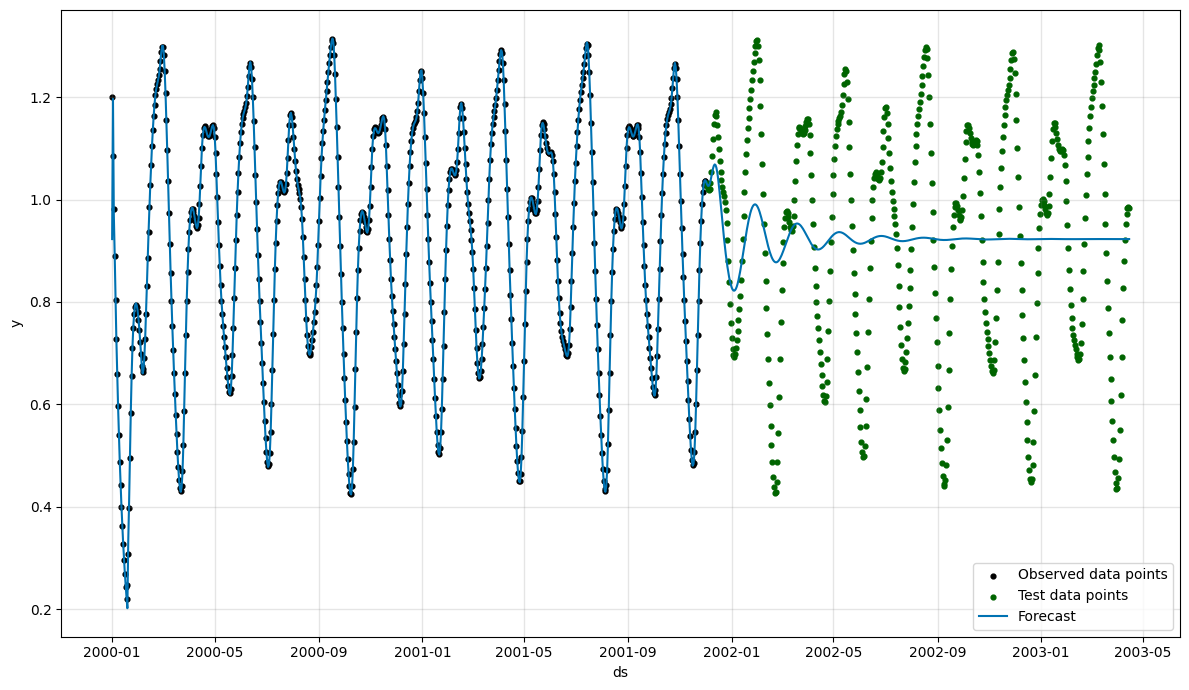

In [80]:
fig = plt.figure(facecolor='w', figsize=(12, 7))
ax = fig.add_subplot(111)
ax.scatter(train_df["ds"], train_df["y"], color="black", label='Observed data points', s=12)
ax.scatter(test_df["ds"], test_df["y"], color="darkgreen", label='Test data points', s=12)
ax.plot(data["ds"], forecast["predicted_mean"], color="#0072B2", label='Forecast')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel("ds")
ax.set_ylabel("y")
ax.legend()
fig.tight_layout()
plt.show()


10 days horizon - rmse = 0.0432
50 days horizon - rmse = 0.089
100 days horizon - rmse = 0.1873
200 days horizon - rmse = 0.1996
300 days horizon - rmse = 0.2086


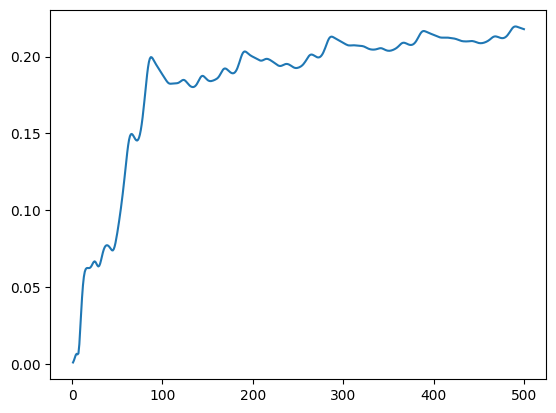

In [81]:
se = (forecast.loc[test_df.index]["predicted_mean"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Sunspots

In [82]:
data = pd.read_csv("../data/Sunspots.csv", index_col=0)
data.columns = ["ds", "y"]
data

,ds,y
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [83]:
pivot = int(data.shape[0] * 0.75)
test_df = data.loc[data.index >= pivot].copy()
train_df =  data.loc[data.index < pivot].copy()

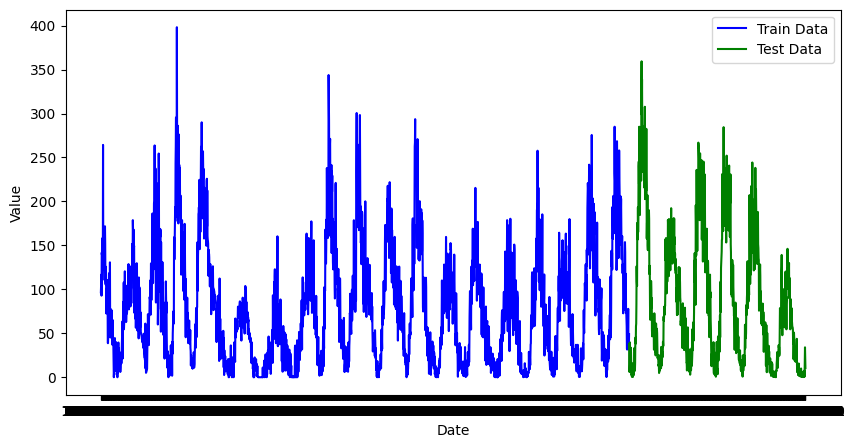

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [85]:
p_params = [1, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [1, 3, 5, 7]
best_rmse = np.inf
best_params = None
result_val = []
train = data.iloc[:800]["y"].copy()
test = data.iloc[800:1300]["y"].copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

p_val=1 d_val=0 q_val=1 --- rmse=66.45721568862815
p_val=1 d_val=0 q_val=3 --- rmse=66.40893872551021
p_val=1 d_val=0 q_val=5 --- rmse=66.46137782027444
p_val=1 d_val=0 q_val=7 --- rmse=66.43939099268712
p_val=1 d_val=1 q_val=1 --- rmse=67.6711805028508
p_val=1 d_val=1 q_val=3 --- rmse=67.4988612884783
p_val=1 d_val=1 q_val=5 --- rmse=67.41550272063573
p_val=1 d_val=1 q_val=7 --- rmse=67.50840303924608
p_val=1 d_val=2 q_val=1 --- rmse=69.14850162588128
p_val=1 d_val=2 q_val=3 --- rmse=71.27202000669955


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=5 --- rmse=783.6899931588805


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=7 --- rmse=821.371325189124
p_val=3 d_val=0 q_val=1 --- rmse=66.41178673062764


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=3 --- rmse=66.38594138582654


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=5 --- rmse=67.19841704297924


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=67.13672794565369
p_val=3 d_val=1 q_val=1 --- rmse=67.4423562757024


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=1 q_val=3 --- rmse=67.68025701871822
p_val=3 d_val=1 q_val=5 --- rmse=67.48157198520141


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=1 q_val=7 --- rmse=67.55127097710458
p_val=3 d_val=2 q_val=1 --- rmse=70.29777875936912


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=3 --- rmse=66.45860039679908


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=5 --- rmse=71.39390729343019


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=7 --- rmse=783.2418378652704
p_val=4 d_val=0 q_val=1 --- rmse=66.42826016649593


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=3 --- rmse=66.40408057449727


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=5 --- rmse=66.40488782379208


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=7 --- rmse=67.14753726304104
p_val=4 d_val=1 q_val=1 --- rmse=67.42505307666576


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=3 --- rmse=67.43894453126444


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=5 --- rmse=67.39494784875295


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=7 --- rmse=67.37726227705463
p_val=4 d_val=2 q_val=1 --- rmse=70.9475118409767


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=3 --- rmse=68.99719025492077


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=5 --- rmse=826.7341556476435


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=7 --- rmse=654.6290255871949
p_val=5 d_val=0 q_val=1 --- rmse=66.43581341307359


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

p_val=5 d_val=0 q_val=3 --- rmse=66.47899109814563


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=0 q_val=5 --- rmse=66.38527100393429


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=7 --- rmse=66.4512552285214
p_val=5 d_val=1 q_val=1 --- rmse=67.42030901828355


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=3 --- rmse=67.31370215664604


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=5 --- rmse=67.38615690268111


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=7 --- rmse=68.57783559262852


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=2 q_val=1 --- rmse=71.51337354124378


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=2 q_val=3 --- rmse=70.33161048299569


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=5 d_val=2 q_val=5 --- rmse=68.4155559439091


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=2 q_val=7 --- rmse=71.9978307574347
best_params=(5, 0, 5)


In [86]:
model = ARIMA(train_df["y"], order=best_params)
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(start=data.index[0], end=data.index[-1]).to_frame()

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2448
Model:                 ARIMA(5, 0, 5)   Log Likelihood              -11389.206
Date:                Tue, 11 Apr 2023   AIC                          22802.412
Time:                        18:04:02   BIC                          22872.049
Sample:                             0   HQIC                         22827.721
                               - 2448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8607     14.182      5.561      0.000      51.065     106.657
ar.L1          0.5068      0.124      4.085      0.000       0.264       0.750
ar.L2          0.6426      0.101      6.354      0.0

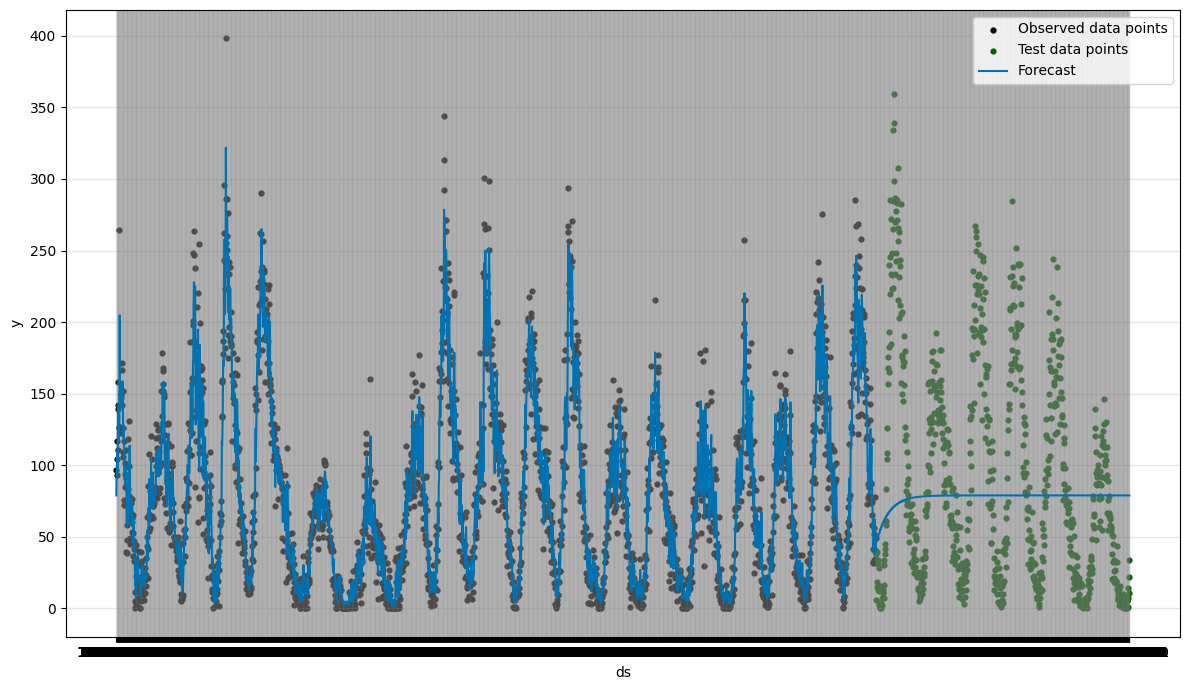

In [87]:
fig = plt.figure(facecolor='w', figsize=(12, 7))
ax = fig.add_subplot(111)
ax.scatter(train_df["ds"], train_df["y"], color="black", label='Observed data points', s=12)
ax.scatter(test_df["ds"], test_df["y"], color="darkgreen", label='Test data points', s=12)
ax.plot(data["ds"], forecast["predicted_mean"], color="#0072B2", label='Forecast')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel("ds")
ax.set_ylabel("y")
ax.legend()
fig.tight_layout()
plt.show()


10 days horizon - rmse = 30.686
50 days horizon - rmse = 84.6734
100 days horizon - rmse = 127.0091
200 days horizon - rmse = 97.6202
300 days horizon - rmse = 84.2338


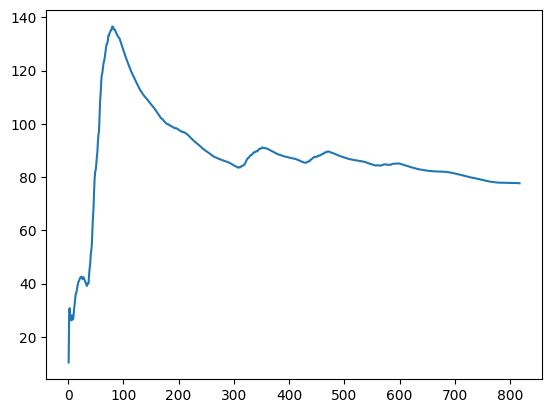

In [88]:
se = (forecast.loc[test_df.index]["predicted_mean"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Electricity

In [89]:
data = pd.read_csv("../data/electricity_consumption_dataset.csv")
data["ds"] = [pd.Timestamp(f"{d} {t}") for d, t in zip(data["Date"], data["Time"])]
data["y"] = data["Consumption Amount (MWh)"].apply(lambda x: float(x.replace(".", "").replace(",",".")))
data = data[["ds", "y"]].sort_values(["ds"]).reset_index(drop=True)
data

,ds,y
0,2015-12-31 00:00:00,29590.88
1,2015-12-31 01:00:00,27785.43
2,2015-12-31 02:00:00,26516.53
3,2015-12-31 03:00:00,26091.62
4,2015-12-31 04:00:00,25871.54
...,...,...
39451,2020-12-06 19:00:00,33328.32
39452,2020-12-06 20:00:00,34326.80
39453,2020-12-06 21:00:00,34294.81
39454,2020-12-06 22:00:00,33305.15


In [90]:
pivot = int(data.shape[0] * 0.75)
test_df = data.loc[data.index >= pivot].copy()
train_df =  data.loc[data.index < pivot].copy()

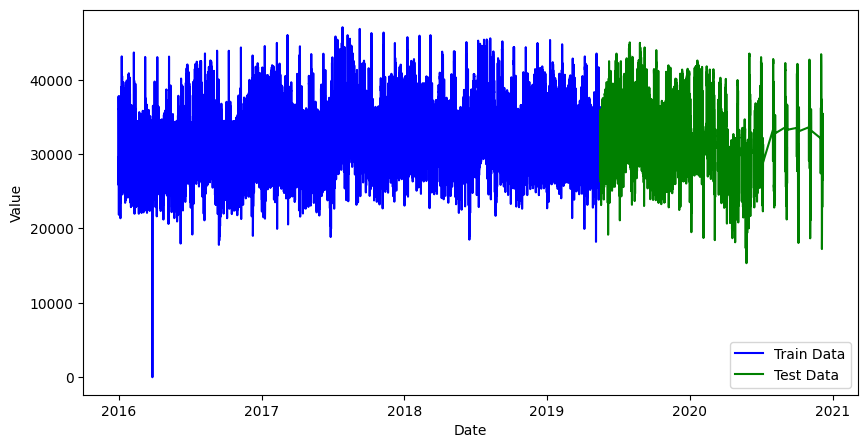

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [92]:
p_params = [1, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [1, 3, 5, 7]
best_rmse = np.inf
best_params = None
result_val = []
train = data.iloc[:800]["y"].copy()
test = data.iloc[800:1300]["y"].copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

p_val=1 d_val=0 q_val=1 --- rmse=4673.692355366729
p_val=1 d_val=0 q_val=3 --- rmse=4662.163065532525
p_val=1 d_val=0 q_val=5 --- rmse=4661.332273568869
p_val=1 d_val=0 q_val=7 --- rmse=4651.434781984885
p_val=1 d_val=1 q_val=1 --- rmse=5033.34854016145
p_val=1 d_val=1 q_val=3 --- rmse=5054.239342564782
p_val=1 d_val=1 q_val=5 --- rmse=4501.882692450124


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=1 q_val=7 --- rmse=4581.906348584073
p_val=1 d_val=2 q_val=1 --- rmse=9759.707716214216
p_val=1 d_val=2 q_val=3 --- rmse=8249.075071835712


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=5 --- rmse=4703.270299363965


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=2 q_val=7 --- rmse=8552.589227227247
p_val=3 d_val=0 q_val=1 --- rmse=4648.332379727755
p_val=3 d_val=0 q_val=3 --- rmse=4628.430422694927


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=0 q_val=5 --- rmse=3622.150536117857


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=4621.050737677112
p_val=3 d_val=1 q_val=1 --- rmse=5041.174338821374
p_val=3 d_val=1 q_val=3 --- rmse=4970.894625045442


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=5 --- rmse=5525.867564566763


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=1 q_val=7 --- rmse=4575.147386559626
p_val=3 d_val=2 q_val=1 --- rmse=7930.3743292271865


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=3 --- rmse=11663.816677247389
p_val=3 d_val=2 q_val=5 --- rmse=7985.858953046619


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=7 --- rmse=4877.183738245923
p_val=4 d_val=0 q_val=1 --- rmse=4638.808250141562
p_val=4 d_val=0 q_val=3 --- rmse=4629.3268032591395


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=5 --- rmse=4624.074759719179
p_val=4 d_val=0 q_val=7 --- rmse=4638.40912052627
p_val=4 d_val=1 q_val=1 --- rmse=5113.175818107069


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=3 --- rmse=4987.638581552476


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=5 --- rmse=4612.359977616632


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=7 --- rmse=4564.2097805851445
p_val=4 d_val=2 q_val=1 --- rmse=153178.86654724044


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=3 --- rmse=4701.699827724506


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=5 --- rmse=8307.670776679099


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=7 --- rmse=4704.088519177948
p_val=5 d_val=0 q_val=1 --- rmse=4641.580068663713


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=3 --- rmse=4593.1421719283


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=5 --- rmse=4459.992999979539


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=0 q_val=7 --- rmse=4621.218888561884
p_val=5 d_val=1 q_val=1 --- rmse=5057.887668102686


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: User

p_val=5 d_val=1 q_val=3 --- rmse=4715.645532925768


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=5 --- rmse=4599.893227257835


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=1 q_val=7 --- rmse=4407.518196111387
p_val=5 d_val=2 q_val=1 --- rmse=156974.98855771465


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=2 q_val=3 --- rmse=6611.587535622763


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=2 q_val=5 --- rmse=13007.068366828267


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=5 d_val=2 q_val=7 --- rmse=4586.3334768548875
best_params=(3, 0, 5)


In [93]:
model = ARIMA(train_df["y"], order=best_params)
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(start=data.index[0], end=data.index[-1]).to_frame()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                29592
Model:                 ARIMA(3, 0, 5)   Log Likelihood             -249415.314
Date:                Tue, 11 Apr 2023   AIC                         498850.627
Time:                        18:08:03   BIC                         498933.580
Sample:                             0   HQIC                        498877.261
                              - 29592                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.26e+04    107.589    303.022      0.000    3.24e+04    3.28e+04
ar.L1          2.3121      0.007    312.286      0.000       2.298       2.327
ar.L2         -2.0252      0.014   -148.919      0.0

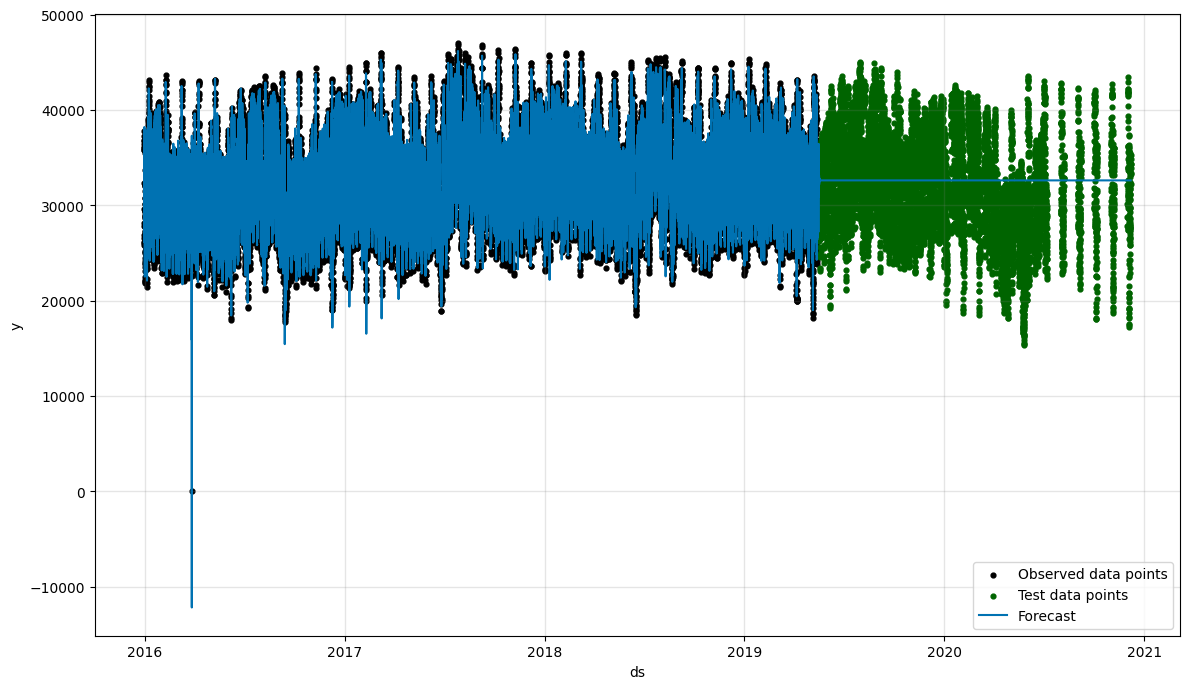

In [94]:
fig = plt.figure(facecolor='w', figsize=(12, 7))
ax = fig.add_subplot(111)
ax.scatter(train_df["ds"], train_df["y"], color="black", label='Observed data points', s=12)
ax.scatter(test_df["ds"], test_df["y"], color="darkgreen", label='Test data points', s=12)
ax.plot(data["ds"], forecast["predicted_mean"], color="#0072B2", label='Forecast')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel("ds")
ax.set_ylabel("y")
ax.legend()
fig.tight_layout()
plt.show()


10 days horizon - rmse = 2119.5028
50 days horizon - rmse = 2496.7886
100 days horizon - rmse = 3679.7827
200 days horizon - rmse = 3501.9582
300 days horizon - rmse = 3558.1312


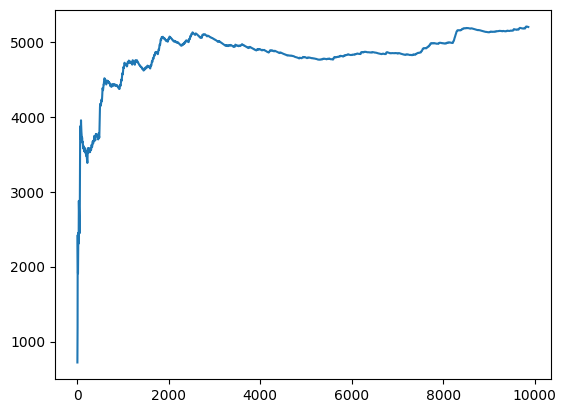

In [95]:
se = (forecast.loc[test_df.index]["predicted_mean"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()